# Assignment 8.1 Gaussian Process for Forecasting
##### ECE517, Machine Learning, University of New Mexico
##### Professor Martinez-Ramon
##### Zachary Montoya

___
The problem statement is as follows:

Construct a script that uses a number of T hours from the 2020 data starting from January to train a GP that forecasts the load with a horizon M. The window has W samples (and therefore p=W-1). The range must be between 24 hours and 168 hours (one week). The forecast must be any number of hours between 1 and 24. 

a) Train a GP using a linear and another one using square exponential kernel for T=1000  (1000 training samples) and M=1 (horizon equal to one hour).

b) Test it with the first week of January, 2021 and plot the mean and confidence intervals of any day of that week. 

c) Test it with the first week of July, 2021 (which starts in day 182) and plot the mean and confidence interval. 

d) Repeat the process for M=6 and M=12

Write a full report of the explanation of the experiments, the presentation of the results and its discussion. Include the numeric values of the parameters of the kernels. What conclusions can be extracted from the comparisons of the results of b and

In [37]:
# Importing Packages
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel as C, WhiteKernel
from sklearn import preprocessing

In [38]:
def sliding_window(x, w = 1, d = 0):
    # This function creates a data array formatted in sliding windows.
    # Parameters: X, the input data, which must be a time series in an array of a singel dimension
    #             w, the width of the window
    #             d, the number of elements of the previous window present in the next one.
    #             For the present homework, we use a window shift of 1 position, so then d = w-1
    #             X is the output, and it is an array with the formatted data.
    N = len(x)
    x=x.reshape(x.size,) 
    m = int(np.ceil((N-w)/(w-d)))
    X = np.zeros([w,m])
    for i,j in zip(range(0,N,w-d),range(0,m)):
        X[:,j] = x[i:i + w]
    return X

def sliding_window1(x, w = 1, d = 0):
    N = len(x)
    m = int(np.ceil((N-w)/(w-d)) + 1)
    X = np.zeros([w,m])
    for i,j in zip(range(0,N,w-d),range(0,m)):
        X[:,j] = x[i:i + w]
    return X

def plot_graphs(y_tst,mean,std,title):
  # This plots the results of the GP prediction, so you do not spend time figuring this out.
  # Parameters: y_tst is the time series of true regressors
  #             mean is the mean value of the prediction
  #             std is the standard deviation of the prediction
  #             tittle is a string with the title that you want to show in the graphic.
  plt.plot(y_tst, label="Observations",color="black")
  plt.plot(mean, label="Mean prediction",color="red")
  plt.fill_between(
    # np.arange(y_tst.size).ravel(),
    np.arange(y_tst.size).ravel(),
    mean - 1.96 * std,
    mean + 1.96 * std,
    alpha=0.5,
    label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$t$")
  plt.ylabel("$f(t)$")
  plt.title(title)
  plt.show()

In [49]:
# Importing the data to a dataframe
cwd = os.getcwd()
data_path = os.path.join(cwd,'ISO data')
data_files = os.listdir(data_path)
df_data = pd.DataFrame()
column_list = []
for file in data_files:
    if file.endswith('.txt'):
        df = pd.read_csv(os.path.join(data_path,file),header=None)
        df_data = pd.concat([df_data,df],axis=1)
    column_list.append(file.split('.')[0])
df_data.columns = column_list
df_data.head()

df_2020_train = df_data.filter(like='2020',axis=1)
df_2020_train.columns = df_2020_train.columns.str.replace('2020_','')
df_2020_train = df_2020_train.sort_index(axis=1)
df_2021_test = df_data.filter(like='2021',axis=1)
df_2021_test.columns = df_2021_test.columns.str.replace('2021_','')
df_2021_test = df_2021_test.sort_index(axis=1)
# df_data.describe()
df_2020_train.describe()

,CT,ME,NEMA,NH,RI,SEMA,VT,WCMA
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,3134.541049,1289.352365,2605.428944,1282.360558,868.768596,1558.803687,564.493640,1778.561567
std,732.184415,216.000574,532.844297,266.295741,209.054681,387.202587,114.193109,350.883200
min,1859.180000,738.000000,1665.770000,769.480000,522.180000,957.070000,178.110000,1119.620000
25%,2613.880000,1124.975000,2219.670000,1090.935000,728.865000,1282.385000,484.955000,1516.895000
50%,3032.990000,1290.860000,2544.790000,1263.455000,837.445000,1495.125000,564.000000,1740.370000
75%,3498.882500,1437.682500,2893.440000,1432.157500,953.562500,1733.590000,645.475000,1989.392500
max,6303.070000,2023.220000,4998.350000,2402.190000,1873.670000,3366.460000,885.450000,3208.450000


In [50]:
df_2021_test.describe()

,CT,ME,NEMA,NH,RI,SEMA,VT,WCMA
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,3178.607189,1334.266356,2650.611943,1304.722928,888.604614,1587.659309,573.733680,1815.663676
std,714.520490,218.795629,533.453800,262.826201,201.795738,383.459369,116.435296,345.873055
min,1927.420000,872.930000,1738.940000,794.220000,549.690000,813.810000,193.580000,1153.300000
25%,2696.355000,1181.755000,2288.977500,1120.107500,755.085000,1322.105000,493.057500,1567.575000
50%,3076.320000,1331.980000,2586.315000,1287.905000,859.620000,1520.585000,575.615000,1775.795000
75%,3553.245000,1477.977500,2921.877500,1458.925000,978.015000,1777.132500,654.302500,2024.375000
max,6504.650000,2325.820000,5220.140000,2462.240000,1840.790000,3454.000000,886.030000,3317.440000


### NOT COMPLETE Attempting to train based on the entire 2020 and 2021 Df

In [61]:
# plt.plot(df_data[:48])
# plt.show()
#
scaler1 = preprocessing.StandardScaler().fit(df_2020_train)
df_2020_train_scaled = scaler1.transform(df_2020_train)
df_2021_test_scaled = scaler1.transform(df_2021_test)

StartWindowTest = 0 # Hours
EndWindowTest = 48 # Hours

StartWindowTrain = 0 # Hours
EndWindowTrain = 24 * 42 # Units: Hours, 42 days

W=15
M=1
Overlap = 1
print(f"The shape of df_2020_train_scaled is {df_2020_train_scaled.shape}")
print(f"The shape of df_2021_test_scaled is {df_2021_test_scaled.shape}")

x_train_windowed2 = sliding_window(df_2020_train_scaled[:-M],W,W-Overlap).T
x_train_windowed2 = x_train_windowed2[StartWindowTrain:EndWindowTrain]
y_train2 = df_2020_train_scaled[M+W-Overlap:].flatten()
y_train2 = y_train2[StartWindowTrain:EndWindowTrain]

x_test_windowed2 = sliding_window(df_2021_test_scaled[:-M],W,W-Overlap).T
x_test_windowed2 = x_test_windowed2[StartWindowTest:EndWindowTest]
y_test2 = df_2021_test_scaled[M+W-Overlap:].flatten()
y_test2 = y_test2[StartWindowTest:EndWindowTest]

print(f"The shape of x_train_windowed2 is {x_train_windowed2.shape}")
print(f"The shape of y_train2 is {y_train2.shape}")
print(f"The shape of x_test_windowed2 is {x_test_windowed2.shape}")
print(f"The shape of y_test2 is {y_test2.shape}")

The shape of df_2020_train_scaled is (8760, 8)
The shape of df_2021_test_scaled is (8760, 8)
The shape of x_train_windowed2 is (1008, 15)
The shape of y_train2 is (1008,)
The shape of x_test_windowed2 is (48, 15)
The shape of y_test2 is (48,)


In [ ]:
hours = df_data.count().max()
days = int(hours/24)
print('The data has {} days and {} hours'.format(days,hours))

The data has 365 days and 8760 hours


In [ ]:
# Parameters
StartWindowTest = 0 # Hours
EndWindowTest = 48 # Hours

StartWindowTrain = 0 # Hours
EndWindowTrain = 24 * 42 # Units: Hours, 42 days 

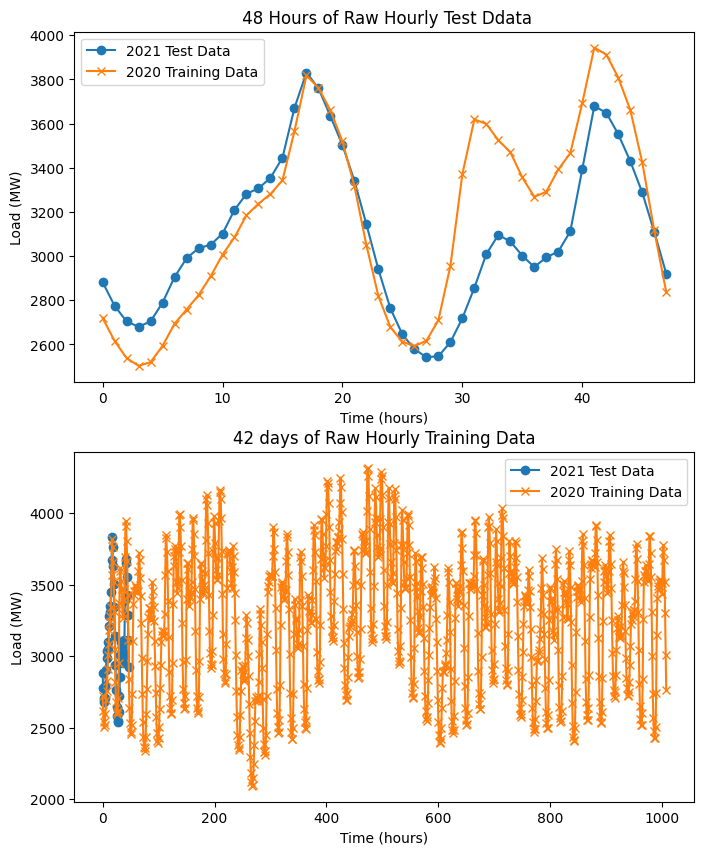

In [ ]:
# Extracting the 2021 CT data
x_test_raw= np.array(df_data[['2021_CT']]).reshape(-1,1)
x_train_raw = np.array(df_data[['2020_CT']]).reshape(-1,1)

plt.figure(figsize=(8,10))

plt.subplot(2,1,1)
plt.plot(x_test_raw[StartWindowTest:EndWindowTest],marker = 'o', label='2021 Test Data')
plt.plot(x_train_raw[StartWindowTrain:EndWindowTest],marker = 'x', label='2020 Training Data')
plt.title(" 48 Hours of Raw Hourly Test Ddata")
plt.xlabel('Time (hours)')
plt.ylabel('Load (MW)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(x_test_raw[StartWindowTest:EndWindowTest],marker = 'o', label='2021 Test Data')
plt.plot(x_train_raw[StartWindowTrain:EndWindowTrain],marker = 'x', label='2020 Training Data')
plt.title("42 days of Raw Hourly Training Data")
plt.xlabel('Time (hours)')
plt.ylabel('Load (MW)')
plt.legend()

plt.show()

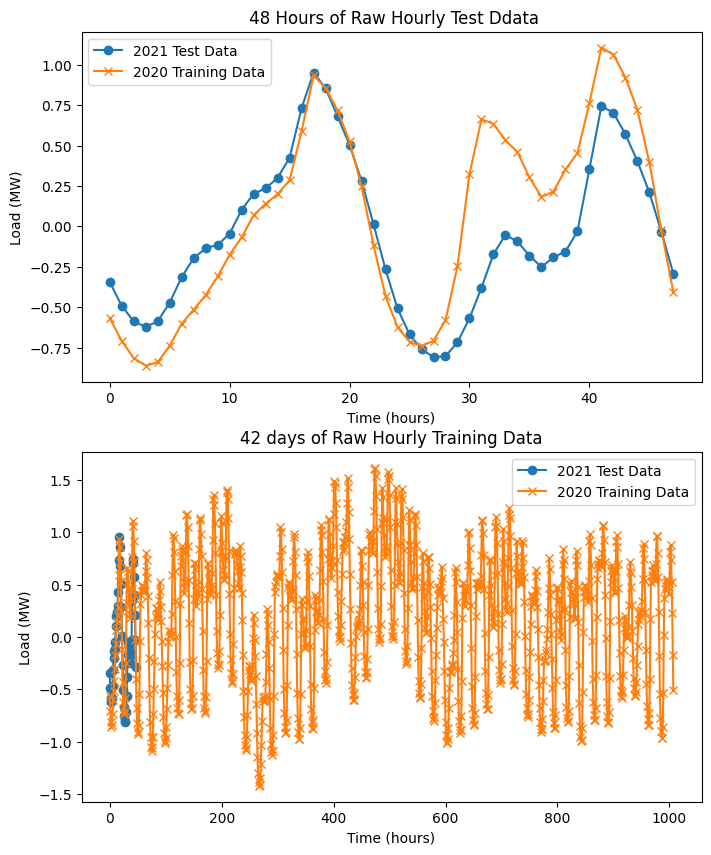

In [ ]:
# Scaling the data about 0 to avoid numerical issues with the GP
scaler = preprocessing.StandardScaler().fit(x_train_raw)
x_test_scaled = scaler.transform(x_test_raw)
x_train_scaled = scaler.transform(x_train_raw)


plt.figure(figsize=(8,10))

plt.subplot(2,1,1)
plt.plot(x_test_scaled[StartWindowTest:EndWindowTest],marker = 'o', label='2021 Test Data')
plt.plot(x_train_scaled[StartWindowTrain:EndWindowTest],marker = 'x', label='2020 Training Data')
plt.title(" 48 Hours of Raw Hourly Test Ddata")
plt.xlabel('Time (hours)')
plt.ylabel('Load (MW)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(x_test_scaled[StartWindowTest:EndWindowTest],marker = 'o', label='2021 Test Data')
plt.plot(x_train_scaled[StartWindowTrain:EndWindowTrain],marker = 'x', label='2020 Training Data')
plt.title("42 days of Raw Hourly Training Data")
plt.xlabel('Time (hours)')
plt.ylabel('Load (MW)')
plt.legend()

plt.show()

In [ ]:
W=15
M=1
Overlap = 1

x_train_windowed = sliding_window(x_train_scaled[:-M],W,W-Overlap).T
x_train_windowed = x_train_windowed[StartWindowTrain:EndWindowTrain]
y_train = x_train_scaled[M+W-Overlap:].flatten()
y_train2 = x_train_scaled[M+W:].flatten()
y_train = y_train[StartWindowTrain:EndWindowTrain]

x_test_windowed = sliding_window(x_test_scaled[:-M],W,W-Overlap).T
x_test_windowed = x_test_windowed[StartWindowTest:EndWindowTest]
y_test = x_test_scaled[M+W-Overlap:].flatten()
y_test2 = x_test_scaled[M+W:].flatten()
y_test = y_test[StartWindowTest:EndWindowTest]

print(f"The shape of x_train_windowed is {x_train_windowed.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of x_test_windowed is {x_test_windowed.shape}")
print(f"The shape of y_test is {y_test.shape}")


The shape of x_train_windowed is (1008, 15)
The shape of y_train is (1008,)
The shape of x_test_windowed is (48, 15)
The shape of y_test is (48,)


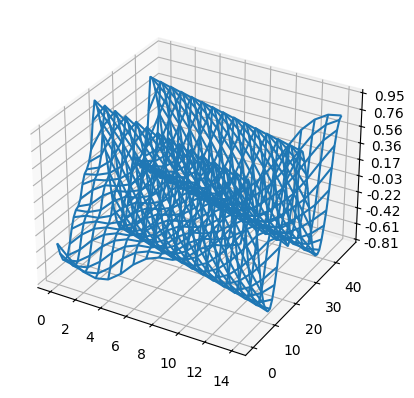

In [ ]:
X = np.arange(0, x_test_windowed.shape[1],1)
Y = np.arange(0, x_test_windowed.shape[0],1)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_wireframe(X,Y,x_test_windowed,antialiased=True)
# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
plt.show()

In [ ]:
kernel = 1 * DotProduct() + WhiteKernel()

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(x_train_windowed, y_train)
mean_prediction, std_prediction = gaussian_process.predict(x_test_windowed, return_std=True)

print(f"GP score on training data:  {gaussian_process.score(x_train_windowed, y_train):.2f}")
print(f"GP score on test data:      {gaussian_process.score(x_test_windowed, y_test):.2f}")
print(f"GP kernel:                  {gaussian_process.kernel_}")

GP score on training data:  0.98
GP score on test data:      0.97
GP kernel:                  0.92**2 * DotProduct(sigma_0=0.00754) + WhiteKernel(noise_level=0.0069)


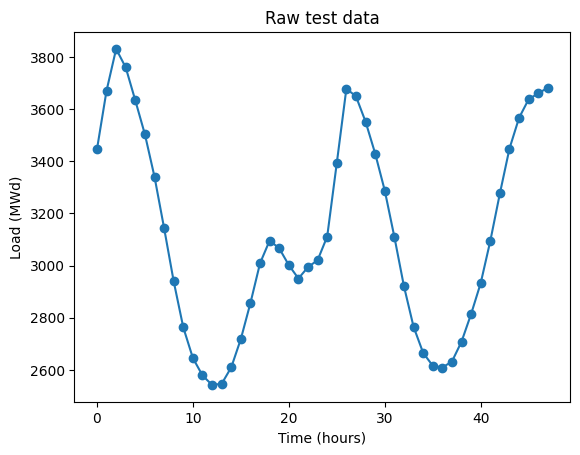

In [ ]:
y_test_trns = scaler.inverse_transform(y_test.reshape(-1,1))
plt.plot(y_test_trns[StartWindowTest:EndWindowTest],marker='o')
plt.title("Raw test data")
plt.xlabel('Time (hours)')
plt.ylabel('Load (MWd)')
plt.show()

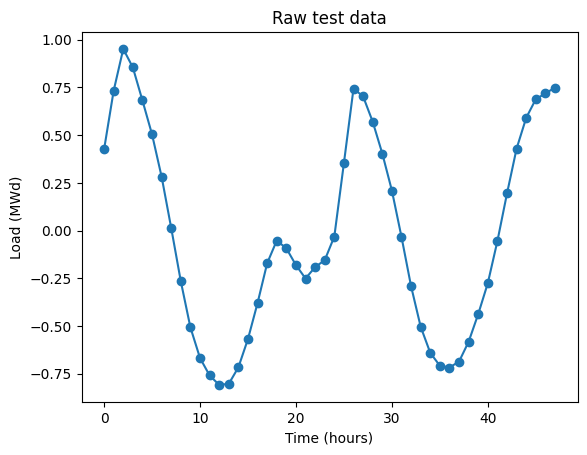

In [ ]:
plt.plot(y_test[StartWindowTest:EndWindowTest],marker='o')
plt.title("Raw test data")
plt.xlabel('Time (hours)')
plt.ylabel('Load (MWd)')
plt.show()

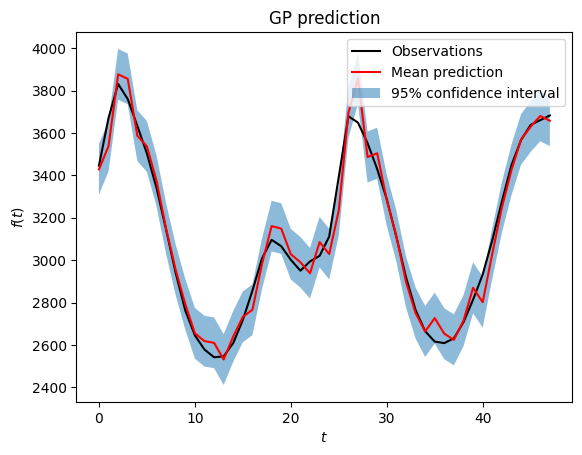

In [ ]:
y_test_trns = scaler.inverse_transform(y_test.reshape(-1,1))
mean_prediction_trns = scaler.inverse_transform(mean_prediction.reshape(-1,1)).flatten()

std_train_data = np.std(x_train_raw)
mean_train_data = np.mean(x_train_raw)
std_prediction_trns = std_prediction * std_train_data

plot_graphs(y_test_trns,mean_prediction_trns,std_prediction_trns,'GP prediction')

In [ ]:
y_test_trns = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

std_train_data = np.std(x_train_raw)
mean_train_data = np.mean(x_train_raw)
y = (y_test * std_train_data) + mean_train_data

for i in range(len(y)):
  if y[i] != y_test_trns[i]: print("Error")

In [ ]:
x = np.arange(30)
W = 10
M = 1
Overlap = 1 
print(x)
print(sliding_window(x[:-M],W,W-Overlap).T)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
 [ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
 [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
 [ 6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
 [ 7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
 [ 8.  9. 10. 11. 12. 13. 14. 15. 16. 17.]
 [ 9. 10. 11. 12. 13. 14. 15. 16. 17. 18.]
 [10. 11. 12. 13. 14. 15. 16. 17. 18. 19.]
 [11. 12. 13. 14. 15. 16. 17. 18. 19. 20.]
 [12. 13. 14. 15. 16. 17. 18. 19. 20. 21.]
 [13. 14. 15. 16. 17. 18. 19. 20. 21. 22.]
 [14. 15. 16. 17. 18. 19. 20. 21. 22. 23.]
 [15. 16. 17. 18. 19. 20. 21. 22. 23. 24.]
 [16. 17. 18. 19. 20. 21. 22. 23. 24. 25.]
 [17. 18. 19. 20. 21. 22. 23. 24. 25. 26.]
 [18. 19. 20. 21. 22. 23. 24. 25. 26. 27.]]
